---
# **データサイエンス基礎　第13回課題**
## **【主成分分析（次元削減）】気象データを次元削減した結果とその考察**
---
### 1. データの概要
　今回扱うデータは，第7，8，10，12回と同様，[気象庁の過去の気象データ](https://www.data.jma.go.jp/gmd/risk/obsdl/index.php)より得られる埼玉県熊谷市の気象データをExcelファイルとしてまとめたものである．
> [https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx](https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx)  
  
　このExcel形式のデータを処理し，気象データ（観測値）をクラスタリングし，作成されたクラスタについて考察する．
### 2. $YYYY$ 年 $MM$ 月の気象データの主成分分析
#### (1) データの読み込み
　まず，各シートの1行目に関して，今回タイトルとして扱いたい情報が含まれない．したがって，1行目を無視する必要がある．また，2，3行目もタイトル行として扱うには不備があり，扱いにくい．以上より，1，2，3行目を無視し，データフレームのタイトル行は自分で定義する必要があると考えられる．  
　また，気象データのうち，独立変数として用いられる可能性があるのは，”平均気温”，”最高気温”，”最低気温”，”降水量”，”日照時間”，”降雪量”，”平均風速”，”平均蒸気圧”，”平均湿度”，”平均現地気圧”の10個である．  
　さらに，電力需要のデータは，1日の1時間毎にデータが記録されている．したがって，この平均値をとり，その日の電力需要とする必要がある．  
　重回帰モデルの作成・出力には，Pythonライブラリであるstatsmodelsを利用する．

In [1]:
# ライブラリの読み込み
# %pip install --upgrade pip
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install openpyxl
# %pip install sympy
# %pip install scipy
# %pip install re
# %pip install jaconv
# %pip install scikit-learn
# %pip install statsmodels
# %pip install seaborn
# %pip install pmdarima
# %pip install kneed
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='seaborn')
warnings.filterwarnings("ignore", category=DeprecationWarning)
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import sympy as sp
import scipy.stats as stats
import re
import jaconv 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import itertools
import matplotlib.dates as mdates
import pmdarima as pm
from IPython.display import clear_output
from sklearn.metrics import r2_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from matplotlib.colors import Normalize


# 変数の定義
year = False                   # 対象年度      ：指定しない場合はFalse
month = False                  # 対象月        ：指定しない場合はFalse

# 対象気象データ名（独立変数候補名）
X_name = ['平均気温', '最高気温', '最低気温', '降水量', '日照時間', '降雪量', '平均風速', '平均蒸気圧', '平均湿度', '平均現地気圧']     

# 対象気象データ名（従属変数候補名）
Y_name = '天気概況'     


# 気象データのExcel Sheetの読み込み
df_weather = pd.read_excel( 'ds07_temp_power_exercise.xlsx', 
                        sheet_name='2020熊谷市気象データ_data', skiprows=[0,1,2],
                        names= ['年月日', '平均気温', '', '', '最高気温', '', '', '', '', '最低気温', '', '', '', '', 
                                '降水量', '', '', '', '日照時間', '', '', '', '降雪量', '', '', '', '平均風速', '', '', 
                                '平均蒸気圧', '', '', '平均湿度', '', '', '平均現地気圧', '', '', '', '', '', '天気概況', '', ''])
df_weather['年月日'] = pd.to_datetime(df_weather['年月日'], format='%Y/%m/%d')


# 対象データの抽出（X：独立変数，Y：従属変数）
def dataLoading(year, month, X_name, Y_name):
    if (year == False) and (month != False) :
        X = df_weather[df_weather['年月日'].dt.month == month][X_name]
        Y = df_weather[df_weather['年月日'].dt.month == month][Y_name]

    elif (year != False) and (month == False):
        X = df_weather[df_weather['年月日'].dt.year == year][X_name]
        Y = df_weather[df_weather['年月日'].dt.year == year][Y_name]

    elif (year == False) and (month == False):
        X = df_weather[X_name]
        Y = df_weather[Y_name]

    else :
        X = df_weather[(df_weather['年月日'].dt.year == year) & (df_weather['年月日'].dt.month == month)][X_name]
        Y = df_weather[(df_weather['年月日'].dt.year == year) & (df_weather['年月日'].dt.month == month)][Y_name]

    return (X, Y)

X_weather, Y_target = dataLoading(year, month, X_name, Y_name)


# データの標準化
stdsc = StandardScaler()
X_weather = stdsc.fit_transform(X_weather)

#### (2) 第1主成分と第2主成分の関係
　第1主成分を横軸，第2主成分を縦軸にとった平面に，各天気概況あるいは各気象データの固有ベクトルをプロットする．

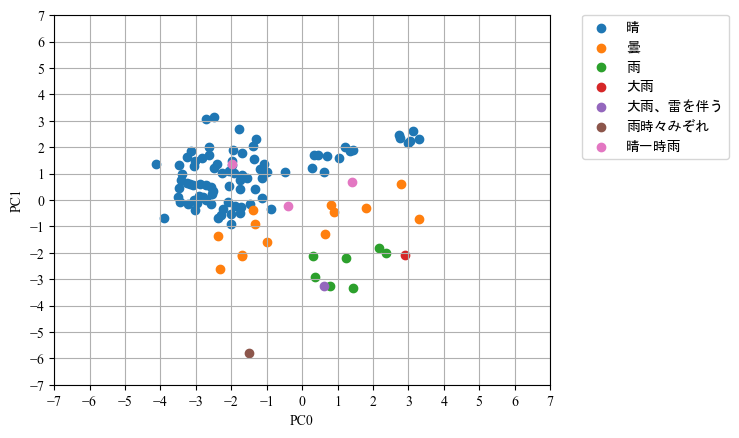

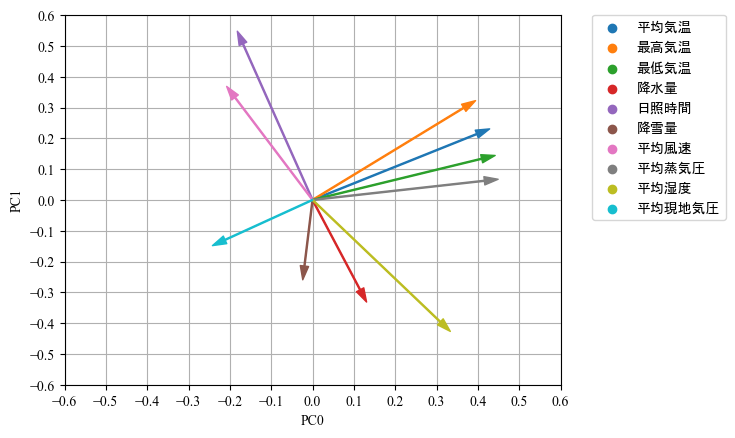

In [61]:
# 主成分分析（主成分空間への写像）
pca = PCA()
pca.fit(X_weather)
pca_cor = pca.transform(X_weather)


# 第1主成分と第2主成分の平面における天気概況の関係をグラフに描画
cmap = cm.get_cmap('tab10')
colors = [cmap(i) for i in range(cmap.N)]
weathers = ['晴', '曇', '雨', '大雨', '大雨、雷を伴う', '雨時々みぞれ', '晴一時雨']
plt.figure()
plt.rcParams['font.family'] = 'Times New Roman'
counter = 0
for weather in weathers:
    color = colors[counter]
    xs = [x for x, name in zip(pca_cor[:, 0], Y_target) if name == weather]
    ys = [y for y, name in zip(pca_cor[:, 1], Y_target) if name == weather]
    plt.scatter(xs, ys, color=color, label=weather)
    counter += 1
plt.grid()
plt.xticks(np.arange(-7, 8))
plt.yticks(np.arange(-7, 8))
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.legend(prop={'family': 'MS Gothic'}, bbox_to_anchor=(1.05, 1.02), loc='upper left')
plt.show()


# 第1主成分と第2主成分の平面における各気象データの関係をグラフ描画
cmap = cm.get_cmap('tab10')
colors = [cmap(i) for i in range(cmap.N)]
plt.figure()
counter = 0
for x, y, name in zip(pca.components_[0], pca.components_[1], X_name):
    color = colors[counter]
    plt.scatter([], [], color=color, label=name)
    plt.annotate(text='', xy=(x,y), xytext=(0, 0),
                arrowprops=dict(shrink=0, width=0.75, headwidth=6, headlength=10, 
                connectionstyle='arc3', facecolor=color, edgecolor=color))
    counter += 1
plt.grid()
plt.xticks(np.arange(-0.6, 0.7, 0.1))
plt.yticks(np.arange(-0.6, 0.7, 0.1))
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.legend(prop={'family': 'MS Gothic'}, bbox_to_anchor=(1.05, 1.02), loc='upper left')
plt.show()

　天気概況のプロットにおいて，みぞれのデータが第2主成分負の方向へずれていることが目立つ．気象データの固有ベクトルを見ると，ベクトルが第2主成分負の方向へ向いていることが確認できる．これまでの課題で，みぞれと降雪量の間には強い（傑出した）相関があることが分かっており，このことが起因していると考えられる．  
　第1主成分に関して，  天気概況の変化は確認できない．気象データを見ると，値が正になると，気温系のパラメータおよび平均蒸気圧が高く，負になると平均現地気圧や日照時間，平均風速が高くなることが確認できる．  
　第2主成分に関して，値が正になると晴れ，負になると悪天候となることが確認できる．気象データに関しても，値が正になると日照時間が長く，負になると平均湿度や降水量・降雪量が高くなることが確認できる．
#### (3) 最適な主成分の数の探索
　累積寄与率を計算し，初めて 0.7 ～ 0.8 の間となったときの主成分の数を最適とした．

The best number of principal components is 3.


,Principal Component,Contribution Rate,Cumulative Contribution Rate
0,PC0,0.470335,0.470335
1,PC1,0.204984,0.675320
2,PC2,0.116504,0.791824
3,PC3,0.089326,0.881150
4,PC4,0.060239,0.941389
5,PC5,0.038235,0.979624
6,PC6,0.014679,0.994303
7,PC7,0.003361,0.997665
8,PC8,0.002087,0.999751
9,PC9,0.000249,1.000000


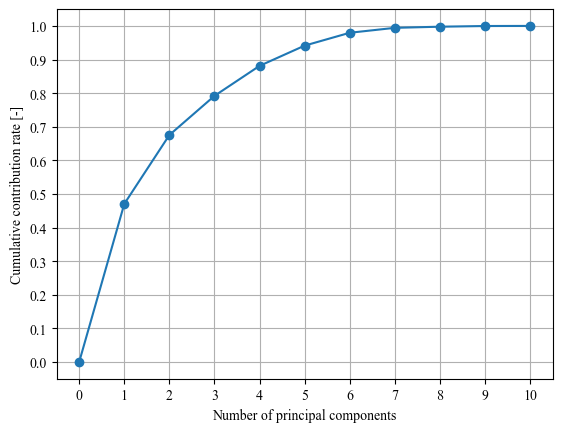

In [3]:
# 寄与率 (累積寄与率)
cumulative_contribution_rate = 0
best_num_pc = 0
ccr_data = []
for i in range(len(X_name)):
    contribution_rate = pca.explained_variance_ratio_[i]
    cumulative_contribution_rate += contribution_rate
    ccr_data.append({
        'Principal Component': f'PC{i}',
        'Contribution Rate': f'{contribution_rate:.6f}',
        'Cumulative Contribution Rate': f'{cumulative_contribution_rate:.6f}'
    })
    if (0.70 < cumulative_contribution_rate < 0.80) and best_num_pc == 0 :
        best_num_pc = i + 1
df_ccr = pd.DataFrame(ccr_data)
print(f'The best number of principal components is {best_num_pc}.')
display(df_ccr)

# 累積寄与率をグラフに描画
plt.figure()
plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xticks(np.arange(0, len(X_name)+1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate [-]")
plt.grid()
plt.show()

　したがって，今回の最適な主成分の数は 3 であると算出された．グラフを確認すると，クラスタ数 3 の部分で概ね傾きが緩やかに転じていることが確認できる．
#### (4) 各気象データの固有ベクトル

,平均気温,最高気温,最低気温,降水量,日照時間,降雪量,平均風速,平均蒸気圧,平均湿度,平均現地気圧
PC0,0.428536,0.394482,0.441874,0.130816,-0.181970,-0.023640,-0.207820,0.449090,0.333427,-0.242195
PC1,0.230670,0.322429,0.144342,-0.331599,0.547803,-0.259399,0.368615,0.067063,-0.426924,-0.148404
PC2,-0.026314,-0.023784,-0.014100,0.560083,0.081502,0.446395,0.513406,-0.028765,-0.039439,-0.461487


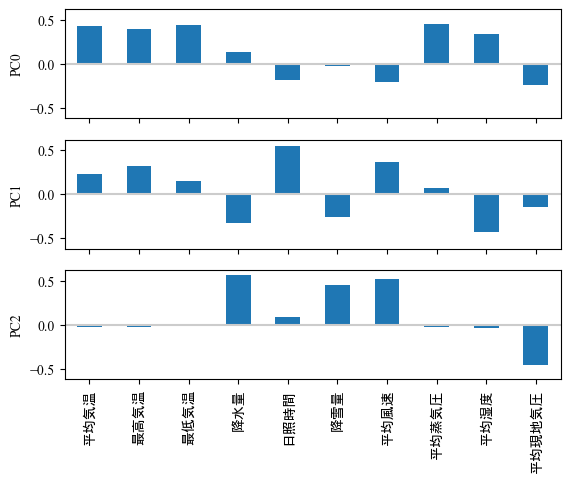

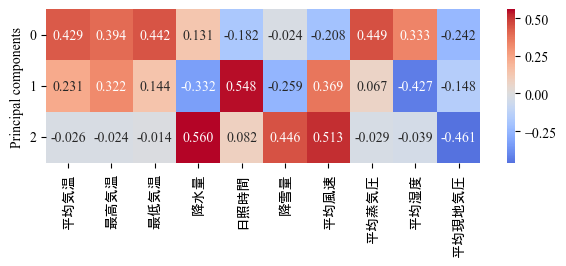

In [4]:
# 各主成分における気象データの固有ベクトル
df_vec = pd.DataFrame(pca.components_[:3], columns=X_name, index=["PC{}".format(x) for x in range(best_num_pc)])
display(df_vec)
centers = pd.DataFrame(pca.components_[:3], columns=X_name)


# 固有ベクトルを棒グラフで描画
f, axes = plt.subplots(best_num_pc, 1, sharex=True)
maxPC = 0.5600832454297913
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'PC{i}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'family': 'MS Gothic'})
    # _maxPC = np.max(np.abs(center))
    # if maxPC < _maxPC :
    #     maxPC = _maxPC
    ax.set_ylim(-1.1*maxPC, 1.1*maxPC)
plt.show()


# 固有ベクトルをヒートマップで描画
plt.figure(figsize=(7, 2))
plt.rcParams['font.family'] = 'Times New Roman'
ax = sns.heatmap(centers, annot=True, fmt=".3f", cmap="coolwarm", center=0, cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'family': 'MS Gothic'})
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.ylabel('Principal components')
plt.show()



#### (4) 第3主成分までの関係 
　第1主成分を $x$ 軸，第2主成分を $y$ 軸，第3主成分を $z$ 軸にとった空間に，各天気概況あるいは各気象データの固有ベクトルをプロットする．

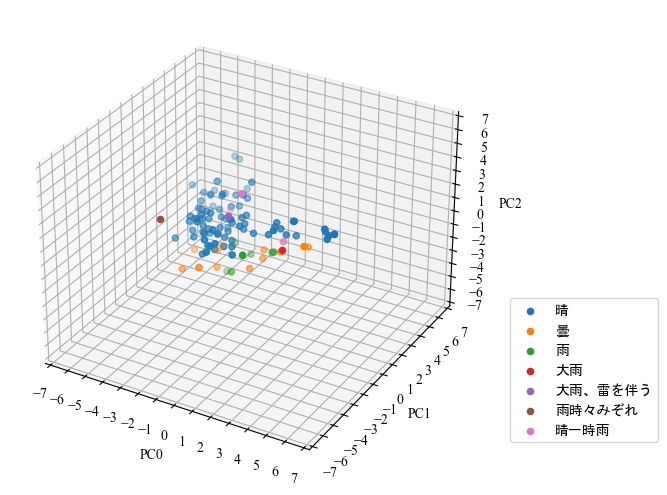

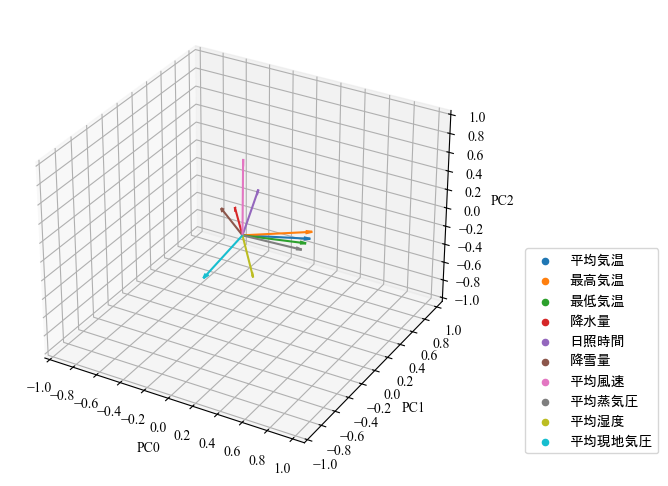

In [60]:
# 第3主成分までの空間における天気概況の関係を3次元グラフに描画
cmap = cm.get_cmap('tab10')
colors = [cmap(i) for i in range(cmap.N)]
weathers = ['晴', '曇', '雨', '大雨', '大雨、雷を伴う', '雨時々みぞれ', '晴一時雨']
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['font.family'] = 'Times New Roman'
counter = 0
for weather in weathers:
    color = colors[counter]
    xs = [x for x, name in zip(pca_cor[:, 0], Y_target) if name == weather]
    ys = [y for y, name in zip(pca_cor[:, 1], Y_target) if name == weather]
    zs = [z for z, name in zip(pca_cor[:, 2], Y_target) if name == weather]
    ax.scatter(xs, ys, zs, color=color, label=weather)
    counter += 1
ax.set_xticks(np.arange(-7, 8))
ax.set_yticks(np.arange(-7, 8))
ax.set_zticks(np.arange(-7, 8))
ax.set_xlabel("PC0")
ax.set_ylabel("PC1")
ax.set_zlabel("PC2")
plt.legend(prop={'family': 'MS Gothic'}, bbox_to_anchor=(1.05, 0.4), loc='upper left')
plt.tight_layout()
plt.show()


# 第3主成分までの空間における各気象データの関係をグラフ描画
cmap = cm.get_cmap('tab10')
colors = [cmap(i) for i in range(cmap.N)]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
counter = 0
for x, y, z, name in zip(pca.components_[0], pca.components_[1], pca.components_[2], X_name):
    color = colors[counter]
    ax.scatter([], [], [], color=color, label=name)
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.1)
    counter += 1
ax.grid()
ax.set_xticks(np.arange(-1.0, 1.2, 0.2))
ax.set_yticks(np.arange(-1.0, 1.2, 0.2))
ax.set_zticks(np.arange(-1.0, 1.2, 0.2))
ax.set_xlabel("PC0")
ax.set_ylabel("PC1")
ax.set_zlabel("PC2")
plt.legend(prop={'family': 'MS Gothic'}, bbox_to_anchor=(1.1, 0.5), loc='upper left')
plt.show()

　主成分分析によって作成された主成分に関して，各主成分における天気概況や，気象データの固有ベクトルの値より，それぞれ以下の表ように考察することができる．
| Principal Component  | － | ＋ | 考察（備考） |
|:---------------:|:------:|:------:|:--------|
| 0  | 乾燥した晴（日照時間・風速・気圧） | 高温多湿（気温・蒸気圧） | 値が正に大きいと気温や蒸気圧が高く，高温多湿な環境であることを意味しており，負に大きいと日照時間・風速・気圧が高く，乾燥した晴天となることを意味する． |
| 1  | 悪天候（雨） | 晴れ（日照時間） | 値が正に大きいと日照時間が長く，晴れることを意味しており，負に大きいと湿度や降水降雪が多く，雨などの悪天候となることを意味する． |
| 2  | 高気圧 | 悪天候（風） | 値が正に大きいと風速や降水降雪が多く，風の強い悪天候となることを意味しており，負に大きいと気圧が高く，高気圧による晴や弱い雨などの天候となることを意味する． |

### 感想  
　主成分分析によって次元削減をすることは，情報を上手く抽出することであり，機械学習などに有効であると考えられるが，人間がその結果を見て，主成分の傾向を掴むのは少し難しかったと感じた．例えるならば，コンピュータ用に分かり易い表現で示されたものを解読している気分であった．今後，機械学習に入力するデータを次元削減して，その効果を検証したいと思った．
　